## The Transformer Architecture

The Transformer is a type of neural network that's good at understanding and generating sequences, like words in a sentence. It does this by paying attention to important parts of the sequence and can process everything at once, making it fast and efficient.

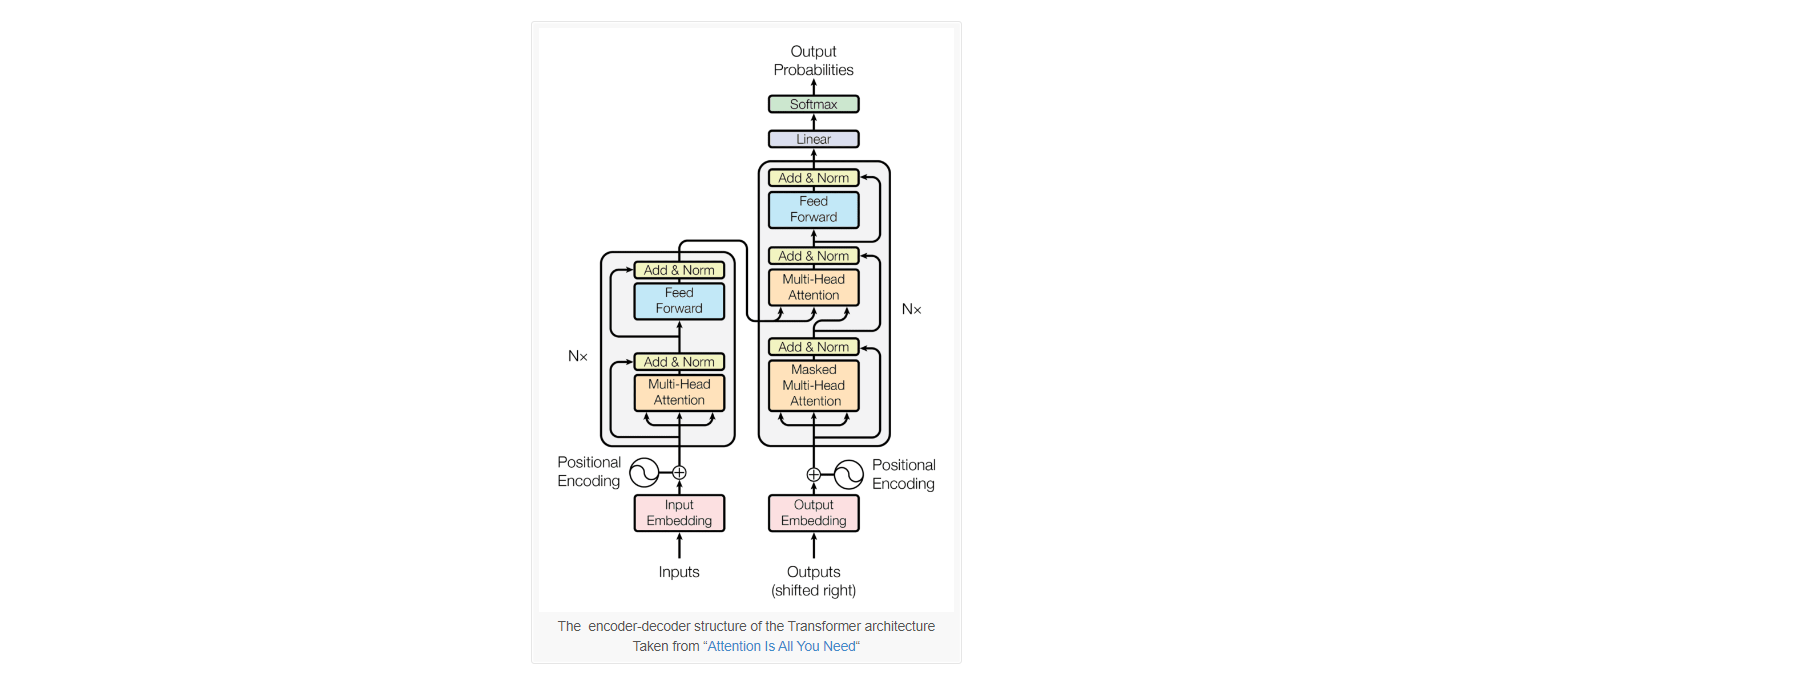

### Table of Contents

1. [Importing Libraries](#1-importing-libraries)
2. [Choosing The Right Embedding Model (Transformer Based)](#2-choosing-the-right-embedding-model-transformer-based)
3. [Loading The bge-m3 Model](#3-loading-the-bge-m3-model)
4. [Sentence Embedding Function](#4-sentence-embedding-function)
5. [compute_similarity Function](#5-compute_similarity-function)
6. [Exploration](#6-exploration)
    - [Vector Dimesnions](#6-1-vector-dimesnions)
    - [Visualizing Our Vector](#6-2-visualizing-our-vector)
7. [Dataset](#7-dataset)
    - [Background](#7-1-background)
    - [Data Gathering](#7-2-data-gathering)
    - [Importing Dataset](#7-3-importing-dataset)
8. [Computing Similarities](#8-computing-similarities)
9. [Assigning Ranges To Our Scores](#9-assigning-ranges-to-our-scores)
10. [Bonus: Leveraging OpenAI for Comparative Analysis](#10-bonus-leveraging-openai-for-comparative-analysis)
    - [Intializing OpenAI Client](#10-1-intializing-openai-client)
    - [Defining GPT Role](#10-2-defining-gpt-role)
    - [Text Generation With GPT](#10-3-text-generation-with-gpt)
    - [Checking How Much We Match In Accordance With The ChatGPT](#10-4-checking-how-much-we-match-in-accordance-with-the-chatgpt)
    - [Visualizing The Comparasion](#10-5-visualizing-the-comparasion)
11. [Fascinating Discoveries](#11-fascinating-discoveries)
12. [Conclusion](#12-conclusion)

### 1. Importing Libraries <a id="1-importing-libraries"></a>

To begin, we import the necessary libraries for our project. These libraries are essential for various tasks such as data manipulation, visualization, and leveraging external APIs.

In [1]:
!pip install sentence-transformers matplotlib python-dotenv openai seaborn pandas numpy

In [ ]:
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from openai import OpenAI
import seaborn as sns
import pandas as pd
import numpy as np
import os

c:\Users\Mubashir.Ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

We load environment variables using dotenv from a .env file, particularly the OPENAI_API_KEY, which we use for accessing the OpenAI API.

### 2. Choosing The Right Embedding Model (Transformer Based) <a id="2-choosing-the-right-embedding-model-transformer-based"></a>

When selecting an appropriate embedding model for natural language processing tasks, it's essential to refer to benchmarks like the Massive Text Embedding Benchmark (MTEB). The MTEB Leaderboard offers valuable insights into the performance of various models.

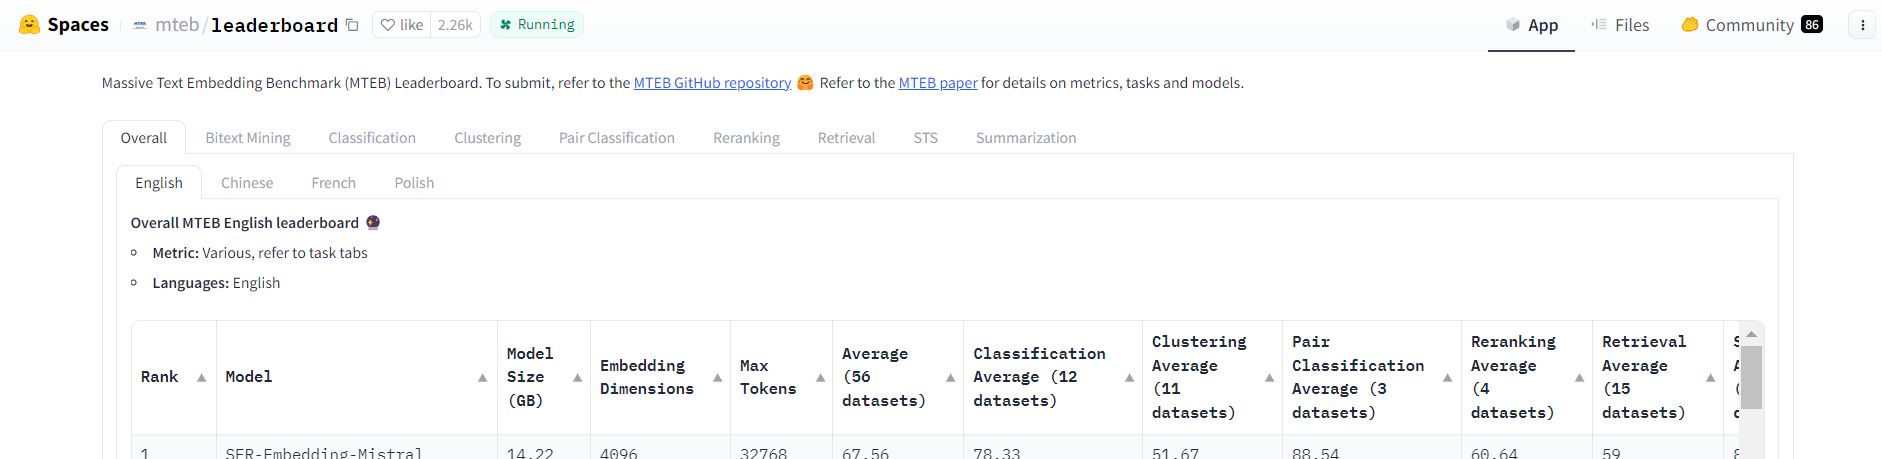

To focus specifically on pair classification tasks in English, we navigate to the Pair Classification English Leaderboard:

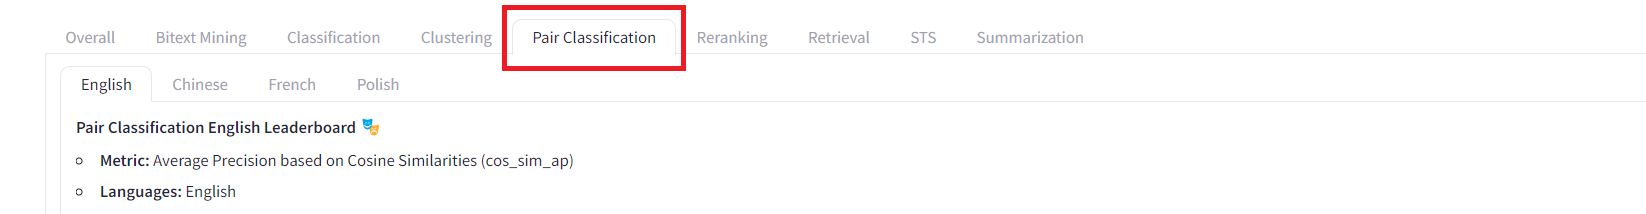

**Pair Classification** involves assigning labels to pairs of text inputs. Typically, these labels denote duplicate or paraphrase pairs. The texts are embedded, and their distance is computed using metrics such as cosine similarity, dot product, Euclidean distance, and Manhattan distance. Performance metrics like accuracy, average precision, F1 score, precision, and recall are computed using the best binary threshold. The average precision score based on cosine similarity serves as the main metric.

For more details, refer to the research paper: [Pair Classification Research Paper](https://arxiv.org/abs/2210.07316)

Sorting the models according to SprintDuplicateQuestions, a dataset from Shah et al. (2018), which comprises questions from the Sprint community. The objective is to classify pairs of sentences as duplicates or not.

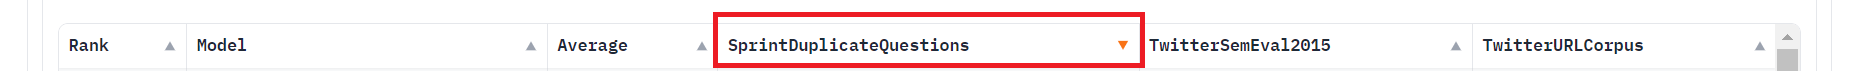

For further information, see the research paper: [SprintDuplicateQuestions Research Paper](https://aclanthology.org/D18-1131/)

Among the top models, we find:

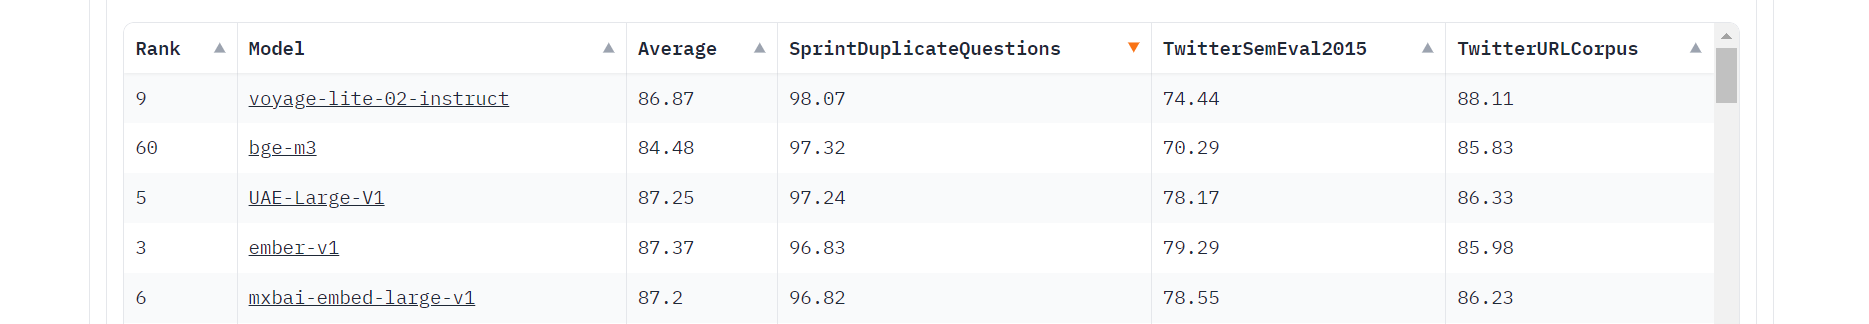

At the top sits "voyage-lite-02-instruct" by voyage.ai, although it appears to be deprecated on the official website for unknown reasons.

Moving to the second model, "bgem3":

[bgem3 Model](https://huggingface.co/BAAI/bge-m3)

This model is available and ready to use. Additionally, it seems to be gaining popularity, as indicated by the accompanying graph:

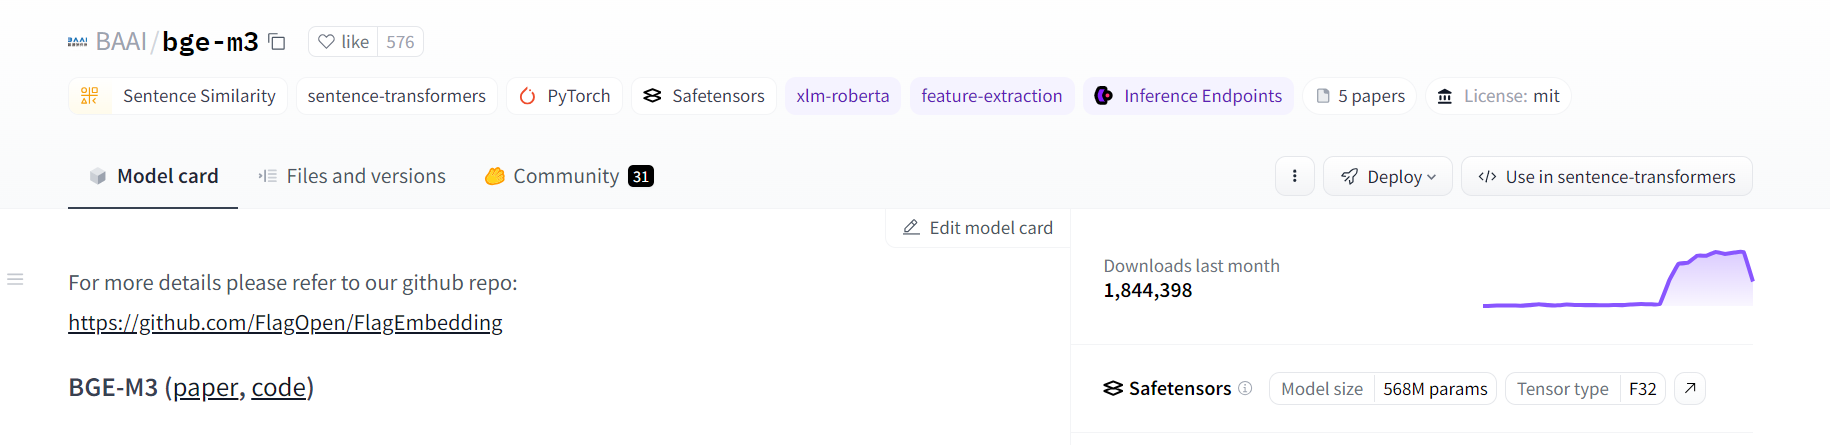


### 3. Loading The bge-m3 Model <a id="3-loading-the-bge-m3-model"></a>

We load the "bgem3" model using the SentenceTransformer library.

In [ ]:
model = SentenceTransformer("BAAI/bge-m3")

c:\Users\Mubashir.Ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Mubashir.Ahmed\.cache\huggingface\hub\models--BAAI--bge-m3. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


### 4. Sentence Embedding Function <a id="4-sentence-embedding-function"></a>

Next, we define a function to embed sentences using the loaded model.

In [4]:
def sentence_embedder(sentence):

  embedded_sentence = model.encode(sentence)

  return embedded_sentence

### 5. compute_similarity Function <a id="5-compute_similarity-function"></a>

This section introduces a function called `compute_similarity()` responsible for computing the cosine similarity between two sentences.

Cosine similarity is chosen due to its effectiveness in measuring the similarity between two vectors, regardless of their magnitude. It is calculated using the formula:

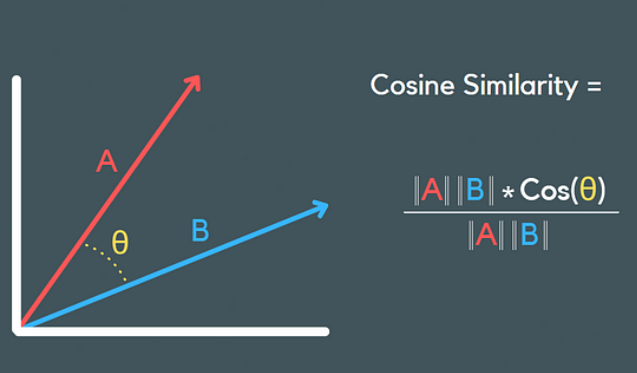

[ImageSource](https://miro.medium.com/v2/resize:fit:600/0*0TXJOSX3l5jRb-Wu.png)

Cosine Similarity (A, B) = 
(A • B) / (||A|| * ||B||)

where A and B are the vectors being compared, and • denotes the dot product. The result ranges from -1 to 1, with 1 indicating perfect similarity, -1 indicating perfect dissimilarity, and 0 indicating no similarity.


We use NumPy functions to perform the necessary calculations and handle cases where the vectors have zero norms to avoid division by zero errors.

In [5]:
def compute_similarity(sentence_1, sentence_2):

  sentence_1_embedding = sentence_embedder(sentence_1)
  sentence_2_embedding = sentence_embedder(sentence_2)

  # Using Cosine Simarity Formula
  dot_product = np.dot(sentence_1_embedding, sentence_2_embedding)
  norm1 = np.linalg.norm(sentence_1_embedding)
  norm2 = np.linalg.norm(sentence_2_embedding)
  if norm1 == 0 or norm2 == 0:
    return 0  # avoids division by zero
  simiarity_score = dot_product / (norm1 * norm2)

  return simiarity_score


### 6. Exploration <a id="6-exploration"></a>

We test the compute_similarity() function with sample sentences:

In [6]:
sim_score1 = compute_similarity("I had a bad day", "I had so much fun")
sim_score2 = compute_similarity("I had a bad day", "Everything was terrible today")

print("Similarity score 1:" , sim_score1)
print("Similarity score 2:" , sim_score2)

Similarity score 1: 0.6380747
Similarity score 2: 0.79764456


In [7]:
sim_score2 > sim_score1

True

#### 6.1. Vector Dimesnions <a id="6-1-vector-dimesnions"></a>

In [8]:
sentence_1_embedding = sentence_embedder("I had a bad day")
sentence_2_embedding = sentence_embedder("I had so much fun")
sentence_2_embedding = sentence_embedder("Everything was terrible today")

In [9]:
sentence_1_embedding.shape

(1024,)

As mentioned in the [BAAI/bge-m3](https://huggingface.co/BAAI/bge-m3), our embedder turns a sentence into a 1024-dimensional vector.

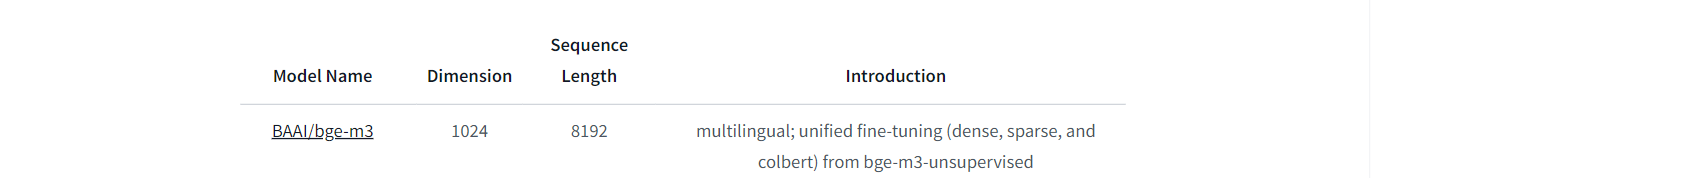

#### 6.2. Visualizing Our Vector <a id="6-2-visualizing-our-vector"></a>

Now let's visualize our vector and see what our all 3 sentences look like.

In [10]:
def plot_embeddings(vectors, labels=None):
    n_vectors = len(vectors)
    fig = plt.figure(figsize=(15, 2) , facecolor='#f5f5f5')  
    ax = plt.gca()

    sns.heatmap(vectors, cmap="coolwarm", vmax=0.1, vmin=-0.1, ax=ax)
    
    if labels:
        ax.set_yticklabels(labels, rotation=0)
        ax.tick_params(axis='both', which='major', labelsize=20)
        
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    
    b, t = plt.ylim()  
    b += 0.5  
    t -= 0.5  

    plt.tight_layout()
    plt.show()

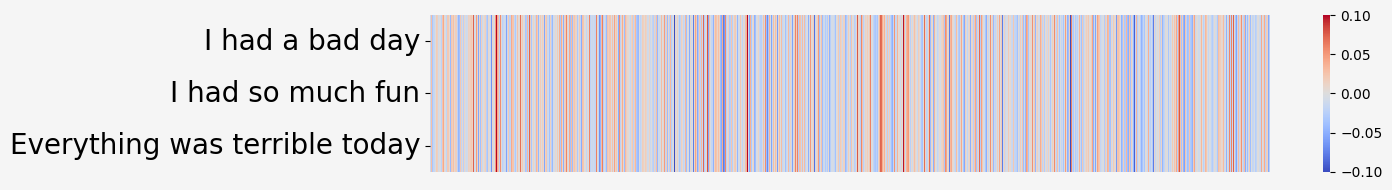

In [11]:
plot_embeddings([sentence_1_embedding , sentence_1_embedding , sentence_1_embedding ],
                ["I had a bad day" , "I had so much fun" , "Everything was terrible today"])

### 7. Dataset <a id="7-dataset"></a>

#### 7.1. Background <a id="7-1-background"></a>

As I searched for a suitable dataset, I came across the [Quora Question Pairs dataset](https://www.kaggle.com/c/quora-question-pairs). Seven years ago, Quora faced a common problem: users repeatedly asked the same questions, leading to redundant answers. This caused frustration among users who had to answer the same questions repeatedly.

While studying this issue and exploring some code examples, I had an idea. Why not create my own dataset and have some fun with it?

Being a movie enthusiast and active in movie communities, I've noticed a recurring debate on platforms like Rotten Tomatoes. This debate revolves around the different opinions of audiences and movie critics. Sometimes, their opinions align, but other times, they clash, sparking heated discussions on platforms like Reddit and Facebook.

Here's a meme from Reddit by u/BeanBagCondor that illustrates this:

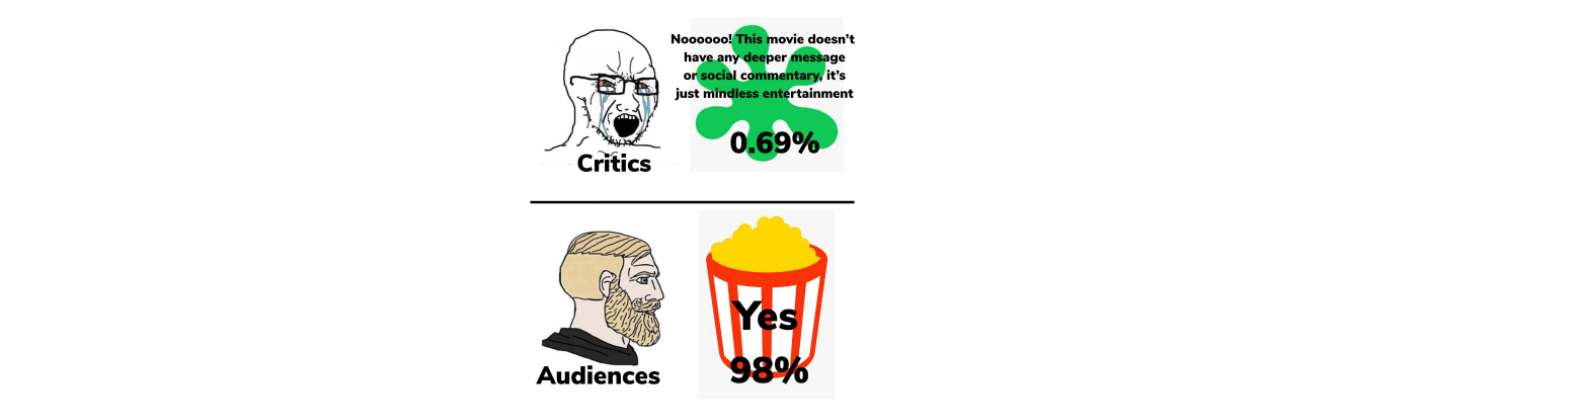

Recently, there was controversy surrounding the The Super Mario Bros. Movie. Critics gave it low scores, but audiences loved it, causing quite a stir:

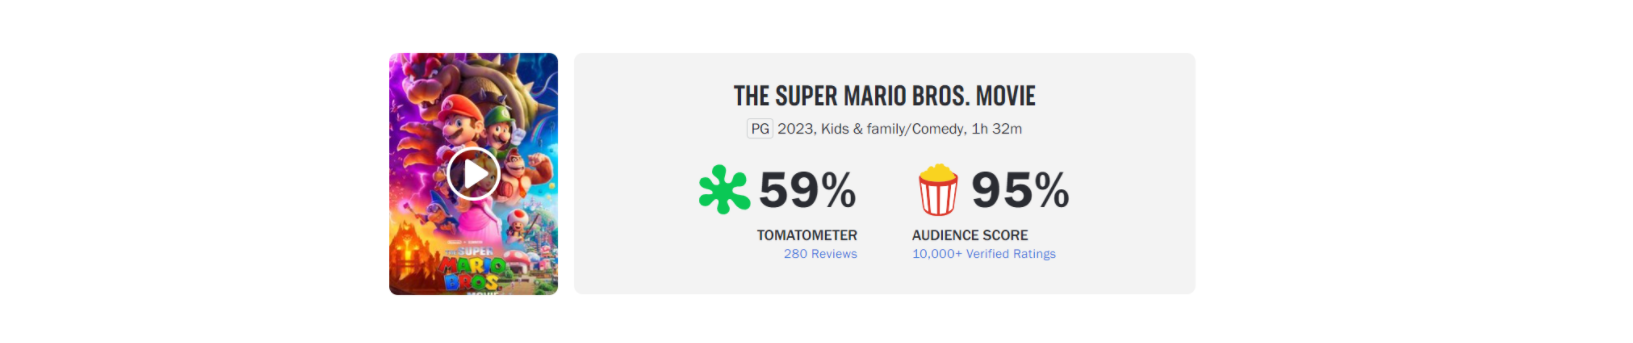

People speculated that older critics might not connect with the movie because they hadn't played the original game and lacked nostalgia.

Another meme by u/ADudeOnTheInternet_, poking fun at the critics' lukewarm reception of "Ant-Man and The Wasp" on Rotten Tomatoes back in 2018.

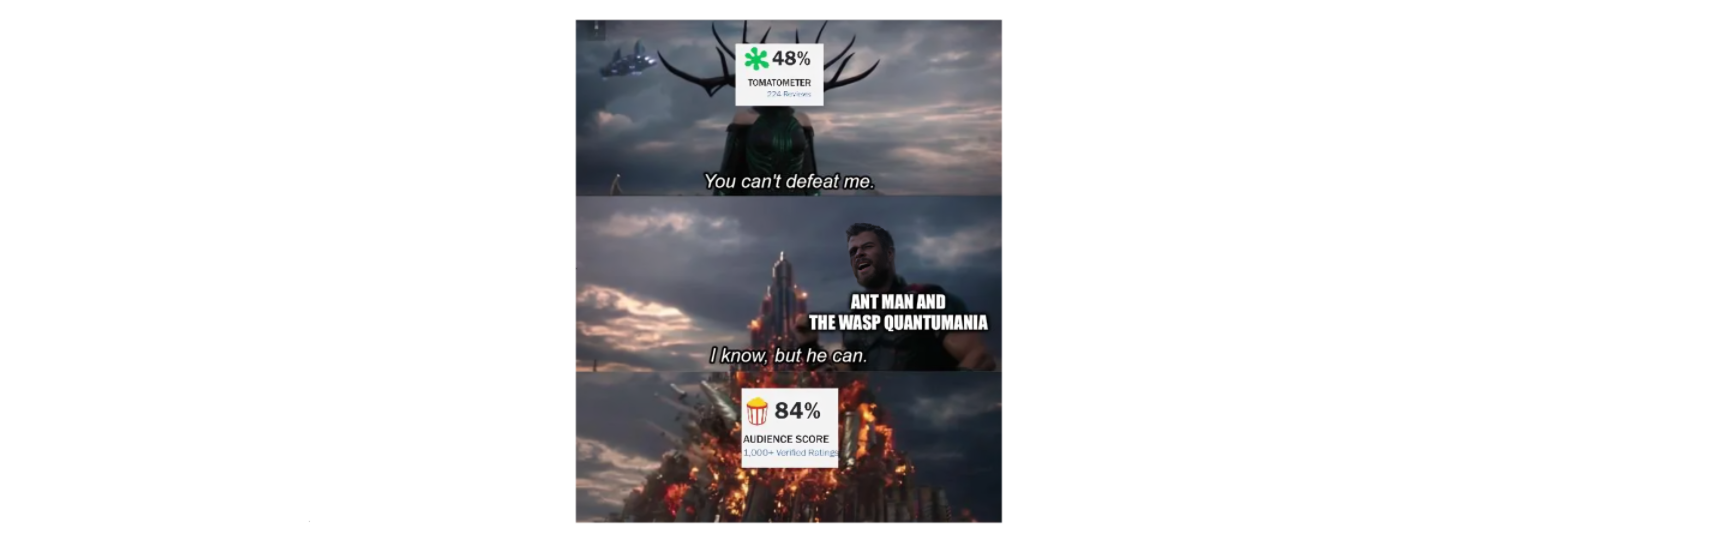

#### 7.2. Data Gathering <a id="7-2-data-gathering"></a>

Now, let's talk about how I collected the data.

For this project, I decided to gather data from [Rotten Tomatoes](https://www.rottentomatoes.com/browse/movies_in_theaters/sort:top_box_office), focusing on the top box office movies of 2024. The data includes the movie's name , audience consensus and critic consensus. I used a combination of web scraping and manual data entry to collect this information.

During the data collection process, I made some changes. For example, I replaced specific nouns with pronouns to make the data more consistent. For instance, "Kung Fu Panda is a great movie" became "It is a great movie".

I've carefully cleaned the collected data, and it's now ready for use. You can find it in the `audience_vs_critics.csv` file.


#### 7.3. Importing Dataset <a id="7-3-importing-dataset"></a>

Next, we import our dataset audience_vs_critic_pronoun.csv using pandas and store it in a DataFrame named df. This dataset contains information about audience and critic consensuses for various movies.

In [12]:
df = pd.read_csv("dataset/audience_vs_critic_pronoun.csv")

In [13]:
df

,id,movie_name,audience_consensus,critics_consensus
0,1,KUNG FU PANDA 4,it is fun for the whole family -- maybe not as...,it offers enough eye-catching entertainment to...
1,2,DUNE: PART TWO,it is nearly three hours of exceptional sci-fi...,"Visually thrilling and narratively epic,it con..."
2,3,ARTHUR THE KING,it is a feel-good movie with enough excitement...,It's hard to deny it ability to tug at the hea...
3,4,IMAGINARY,it passes the time painlessly and has some sca...,it's core concept is solid enough to produce a...
4,5,BOB MARLEY: ONE LOVE,it is a moving glimpse into a brief period of ...,Actor does an admirable job in the central ro...
5,6,ORDINARY ANGELS,it is an engrossing fact-based story that pack...,"With a dash of grace and circumstance, this sw..."
6,7,MIGRATION,"With cute characters, a fun, fast-paced story,...",Beautiful animation and entertaining work from...
7,8,OPPENHEIMER,itis an intelligent movie about an important t...,it marks another engrossing achievement from D...
8,9,AMERICAN FICTION,"Smart, funny, and poignant, it will make you l...",it will forever be inextricable thanks to the ...
9,10,POOR THINGS,"it is a weird, wild good time and Emma Stone i...",Wildly imaginative and exhilaratingly over the...


### 8. Computing Similarities <a id="8-computing-similarities"></a>

In this section, we compute similarity scores between audience and critic consensuses using a custom function compute_similarity(). This function calculates the cosine similarity between two input sentences.

In [14]:
similarity_score_list = []

In [15]:
for index, row in df.iterrows():

    movie_name = row["movie_name"]
    audience_consensus = row["audience_consensus"]
    critics_consensus = row["critics_consensus"]
    
    similarity_score = compute_similarity(audience_consensus , critics_consensus)

    similarity_score_list.append(similarity_score)

In [16]:
df["similarity_score"] = similarity_score_list

### 9. Assigning Ranges To Our Scores <a id="9-assigning-ranges-to-our-scores"></a>

After computing the similarity scores, we assign ranges to these scores based on predefined criteria. The ranges are categorized as "Strong", "Moderate", and "Weak", depending on the magnitude of the similarity score

In [17]:
def ordinal_similarity_score(score):
    if score >= 0.7:
        return "Strong"
    elif score >= 0.5:
        return "Moderate"
    else:
        return "Weak"

In [18]:
df["ordinal_similarity_score"] = df["similarity_score"].apply(ordinal_similarity_score)

### 10. Bonus: Leveraging OpenAI for Comparative Analysis <a id="10-bonus-leveraging-openai-for-comparative-analysis"></a>

This section involves leveraging the OpenAI API to obtain responses categorizing similarity based on the GPT model. We initialize an OpenAI client and define the role of the GPT model for our task.

#### 10.1. Intializing OpenAI Client <a id="10-1-intializing-openai-client"></a>

In [ ]:
client = OpenAI(api_key = "OPENAI_API_KEY")

#### 10.2. Defining GPT Role <a id="10-2-defining-gpt-role"></a>

In [20]:
gpt_role = """Your job is to analyze similarity between two movie consensus sentences (audience and critic). 

**Output:**

Choose one strict option to output:
- "Strong" 
- "Moderate" 
- "Weak" 

**No additional output**

"""

#### 10.3. Text Generation With GPT <a id="10-3-text-generation-with-gpt"></a>

Using the OpenAI API, we generate text responses from the GPT model based on the input movie consensuses. These responses serve as an alternative benchmark for comparison with our cosine similarity-based model.

In [21]:
gpt_response_list = []

In [22]:
for index, row in df.iterrows():

    movie_name = row["movie_name"]
    audience_consensus = row["audience_consensus"]
    critics_consensus = row["critics_consensus"]

    response = client.chat.completions.create(
    model="gpt-3.5-turbo-1106",
    messages=[{"role": "system", "content": gpt_role},
    {"role": "user", "content": f"audience_consensus : {audience_consensus} , critics_consensus : {critics_consensus}"}],
    temperature=0.2,
    max_tokens=500
    )

    gpt_response = response.choices[0].message.content
    gpt_response_list.append(gpt_response)

In [23]:
df['gpt_response'] = gpt_response_list

#### 10.4. Checking How Much We Match In Accordance With The ChatGPT <a id="10-4-checking-how-much-we-match-in-accordance-with-the-chatgpt"></a>

We compare the similarity classifications obtained from our cosine similarity-based model with those generated by the GPT model. This comparison helps evaluate the effectiveness of our approach.

In [24]:
df

,id,movie_name,audience_consensus,critics_consensus,similarity_score,ordinal_similarity_score,gpt_response
0,1,KUNG FU PANDA 4,it is fun for the whole family -- maybe not as...,it offers enough eye-catching entertainment to...,0.601639,Moderate,Moderate
1,2,DUNE: PART TWO,it is nearly three hours of exceptional sci-fi...,"Visually thrilling and narratively epic,it con...",0.687764,Moderate,Strong
2,3,ARTHUR THE KING,it is a feel-good movie with enough excitement...,It's hard to deny it ability to tug at the hea...,0.578590,Moderate,Moderate
3,4,IMAGINARY,it passes the time painlessly and has some sca...,it's core concept is solid enough to produce a...,0.633821,Moderate,Moderate
4,5,BOB MARLEY: ONE LOVE,it is a moving glimpse into a brief period of ...,Actor does an admirable job in the central ro...,0.536289,Moderate,Moderate
5,6,ORDINARY ANGELS,it is an engrossing fact-based story that pack...,"With a dash of grace and circumstance, this sw...",0.658249,Moderate,Moderate
6,7,MIGRATION,"With cute characters, a fun, fast-paced story,...",Beautiful animation and entertaining work from...,0.714649,Strong,Moderate
7,8,OPPENHEIMER,itis an intelligent movie about an important t...,it marks another engrossing achievement from D...,0.672817,Moderate,Moderate
8,9,AMERICAN FICTION,"Smart, funny, and poignant, it will make you l...",it will forever be inextricable thanks to the ...,0.667118,Moderate,Moderate
9,10,POOR THINGS,"it is a weird, wild good time and Emma Stone i...",Wildly imaginative and exhilaratingly over the...,0.705753,Strong,Strong


In [25]:
(df['ordinal_similarity_score'] == df['gpt_response']).value_counts()

True     13
False     4
Name: count, dtype: int64

#### 10.5. Visualizing The Comparasion <a id="10-5-visualizing-the-comparasion"></a>

Finally, we visualize the comparison between GPT responses and ordinal similarity scores using a grouped bar plot. This visualization provides insights into the agreement between the two classification methods.

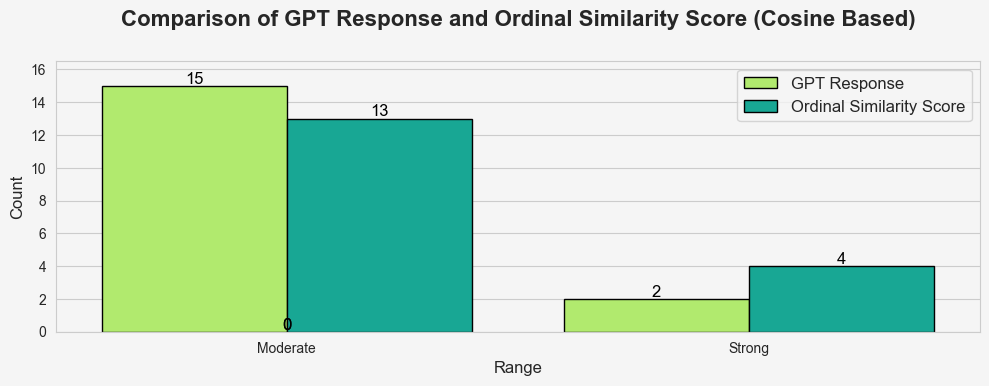

In [26]:
# Prepare data
gpt_response_counts = df["gpt_response"].value_counts().values
similarity_score_counts = df["ordinal_similarity_score"].value_counts().values

data = {
    'Range': ['Moderate', 'Strong'],
    'GPT Response': gpt_response_counts,
    'Ordinal Similarity Score': similarity_score_counts
}

# Convert data to DataFrame
df_data = pd.DataFrame(data)

# Reshape DataFrame to long format
df_long = pd.melt(df_data, id_vars='Range', var_name='Legend', value_name='Value')

# Set style with background color
sns.set_style("whitegrid", {'axes.facecolor': '#f5f5f5'}) 

# Set figure size and background color
plt.figure(figsize=(10, 4), facecolor='#f5f5f5')  

# Create a custom color palette
custom_palette = ['#B2FF59', '#00BFA5']
sns.color_palette("crest", as_cmap=True)

# Create grouped bar plot with custom palette
sns.barplot(data=df_long, x='Range', y='Value', hue='Legend', palette=custom_palette, edgecolor='black')

# Add title and labels with increased font size
plt.title('Comparison of GPT Response and Ordinal Similarity Score (Cosine Based)', fontsize=16, fontweight='bold', y=1.1)
plt.xlabel('Range', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add legend with increased font size
plt.legend(fontsize=12)

# Adjust y-axis limits to have a bit of space at the top
plt.ylim(0, max(max(gpt_response_counts), max(similarity_score_counts)) * 1.1)

# Add data labels on top of bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                        textcoords='offset points')

# Display plot
plt.tight_layout()
plt.show()

### 11. Fascinating Discoveries <a id="11-fascinating-discoveries"></a>

Our dive into the top-grossing movies of 2024 uncovered something interesting: critics and audiences aren't as different as we might think. Despite the hype, movies like "Mario" and "Ant-Man and the Wasp" showed us that people's opinions can vary widely.

In the end, we realized that critics are just like us—they have similar views most of the time. This discovery highlights the common ground we share and reminds us that our perspectives often overlap. Today's exploration has given us a new appreciation for the diversity of opinions that shape our conversations about movies.

### 12. Conclusion <a id="12-conclusion"></a>

We selected the "bgem3" model for sentence embedding and computed cosine similarity scores between audience and critic consensuses for top box office movies of 2024. Our analysis categorized similarity into "Strong", "Moderate", and "Weak" ranges. Additionally, we integrated the OpenAI GPT model for comparative analysis. The comparison, visualized through a grouped bar plot, highlights the effectiveness of cosine similarity in capturing semantic similarity.